<a href="https://colab.research.google.com/github/achluky/EL-7007-DeepFace/blob/main/DeepFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Pengenalan Wajah Anggota Kelas dengan DeepFace**
### **<center>Ahmad Luky Ramdani - 33221020**
### **<center>Varuliantor Dear - 33218010**


---




# Pengenalan Wajah

Melakukan prediksi kemiripian gambar dengan menggunakan library deepface [link](https://github.com/serengil/deepface). Sistem mampu mendeteksi wajah dengan katagori `anggota kelas` dan `bukan anggota kelas`. Sehingga dalam eksperimen ini terdapat dua dataset yaitu dataset individu dalam anggota kelas dan dataset bukan anggota kelas.

Pada eksperimen ini dilakukan beberapa tahapan yaitu:

1. Menginstall Packgae yang dibutuhkan
2. Membuat dataset
3. Melakukan analisis data eksperimen dengan menggunakan data test
4. Implementasi model terbaik

Pada implementasi sistem mampu mengidetifikasi wajah dengan alur sebagai berikut:

1. Jika sistem berhasil mengenali wajah: `<Foto+Label dari Test Data> <Foto+Label dari Database pas foto> Benar/Salah`

2. Jika sistem tidak berhasil mengenali wajah: `<Foto+Label Test Data> Unknown Benar/Salah `

# Menginstall Package

Package python yang diperlukan dalam melakukan eksperimen ini adalah
1. deepface 
2. matplotlib
3. pandas
4. numpy

Berikut code untuk proses installasi package

In [1]:
%pip install deepface matplotlib numpy pandas

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 60.5 MB 101 kB/s 
     |████████████████████████████████| 87 kB 3.8 MB/s 
     |████████████████████████████████| 2.3 MB 31.1 MB/s 
     |████████████████████████████████| 462 kB 29.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=4aabdb621192a7169b826b17bc6e8c09cfe5a64709ff32d7b1d6776eb7013da1
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have im

# Mengambil dataset dari Github

Dataset terdiri dari dua bagian yang disimpan dalam Github yaitu 
1. Dataset Training (basisdata wajah)
2. Dataset Testing

Pada dataset training terdapat 2 directory yang menyatakan informasi kategori data yaitu kategori **"anggota kelas"** dan **"bukan anggota kelas (unknow)"**. Kategori tersebut merepresentasikan class yang terdapat pada eksperimen ini. Yaitu class **"anggota_kelas"** dan **"non_anggota_kelas/unknow"**

Pada **Dataset test** berisi **50% data anggota kelas** dan **50% data bukan anggota kelas**, yang mana gambar yang digunakan berbeda dengan dataset training

In [2]:
!git clone https://github.com/achluky/EL-7007-DeepFace.git

Cloning into 'EL-7007-DeepFace'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 131 (delta 10), reused 126 (delta 7), pack-reused 0
Receiving objects: 100% (131/131), 28.15 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
# Path Data
path_train = '/content/EL-7007-DeepFace/Data/Data_Set/'
path_test = '/content/EL-7007-DeepFace/Data/Data_Test/'

# Mendefinisikan Fungsi

Script dibawah ini dimaksudkan untuk membuat dataset berupa deteksi wajah dari semua gambar yang telah dikumpulkan secara kolektif oleh kelas EL-7007. Dari gambar yang ada dilakukan proses deteksi wajah (croping) yang mana hanya bagian wajah saja yang akan dijadikan dataset eksperimen. Sehingga terdiri dari 2 proses yaitu

1. face detection & alignment
2. face normalization
3. face represent

In [4]:
# import library yang dibutuhkan
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepface import DeepFace
from deepface.commons import functions, distance as dst
from PIL import Image

# Library untuk mengukur kualitas model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [5]:
# Fungsi membaca directory
def read_directory(path):
  img_paths = []
  for root, directory, files in os.walk(path):
      for file in files:
          img_paths.append(root+"/"+file)
  return img_paths

In [6]:
# Fungsi membaca directory
def read_directory_file_name(path):
  imgs = []
  for root, directory, files in os.walk(path):
      for file in files:
          img = []
          img.append(root+"/"+file)
          img.append(file.rsplit('.', 1)[0])
          imgs.append(img)
  return imgs

In [7]:
# Fungsi untuk menentukan model
def load_model(model_name):
  model = DeepFace.build_model(model_name)
  return model

In [8]:
#decide input shape
def input_shape(model_build):
  input_shape_x, input_shape_y = functions.find_input_shape(model_build)
  return input_shape_x, input_shape_y

In [9]:
#detect and align
def detect_align(img_path, target_size, enforce_detection, detector_backend, align=True):
  img = functions.preprocess_face(img = img_path
                                    , target_size= target_size
                                    , enforce_detection = enforce_detection
                                    , detector_backend = detector_backend
                                    , align = align)
  return img

In [10]:
# normalization
def normalization(img, normalization='base'):
  img = functions.normalize_input(img = img, normalization = normalization)
  return img

In [11]:
# represent
def represent(model, img):
  embedding = model.predict(img)[0].tolist()
  return embedding

# Preprocessing Data


Tahapan ini untuk mendefinisikan data dalam suatu bentu dataframe yang siap untuk dilakukan proses analisis

In [12]:
# Fungsi Preprocessing Data
def preprocess_face(model, img_paths, target_size, enforce_detection=True, detector_backend='mtccn'):
  instances = []
  #for facial_img_path in img_paths:
  for i in tqdm(range(0, len(img_paths))):
    facial_img_path = img_paths[i]
    # detect_align
    facial_img = detect_align(facial_img_path, target_size, enforce_detection, detector_backend)
    # normalization
    facial_img_norm = normalization(facial_img)
    # represent gambar wajah
    embedding_img = represent(model, facial_img_norm)
    # nama file
    pathname, extension = os.path.splitext(facial_img_path)
    filename = pathname.split('/')
    # add instance
    instance = []
    instance.append(filename[-1])
    instance.append(facial_img_path)
    instance.append(facial_img)
    instance.append(embedding_img)
    instances.append(instance)
  return instances

In [13]:
# Fungsi Preprocessing Data
def preprocess_face_DataTest(model, img_paths, target_size, enforce_detection=True, detector_backend='mtccn'):
  instance = []
  facial_img_path = img_paths
  # detect_align
  facial_img = detect_align(facial_img_path, target_size, enforce_detection, detector_backend)
  # normalization
  facial_img_norm = normalization(facial_img)
  # represent gambar wajah
  embedding_img = represent(model, facial_img_norm)
  # nama file
  pathname, extension = os.path.splitext(facial_img_path)
  filename = pathname.split('/')
  # add instance
  instance.append(filename[-1])
  instance.append(embedding_img)
  return instance

# Eksperimen

## Analisis Model dan Face Detector

Adapun dataset yang dibuat berdasarkan hasil proses deteksi wajah oleh algoritma tertentu dan model representasi wajah. 

Model representasi wajah dan deteksi wajah yang digunakan adalah sebagai berikut:

- Teknik deteksi wajah (face detector)
1. opencv 
2. ssd 
3. dlib 
4. mtcnn 
5. retinaface
6. mediapipe

- Model Representasi wajah (model arsitektur face recognition)
1. VGG-Face 
2. Facenet 
3. Facenet512 
4. OpenFace 
5. DeepFace 
6. DeepID 
7. ArcFace 
8. Dlib 
9. SFace

### Dataset Perbandingan Model

Dibuat berdasarkan pada kombinasi antara teknik deteksi wajah dan model representasi wajah (model face recognition). Adapun teknik deteksi wajah digunakan secara *default* yaitu "**opencv**". 

Format nama file dataset: 
```
df_data_m:NAMA_MODEL_REPRESENTASI_WAJAH_f_detect:TEKNIK_DETEKSI_WAJAH.csv
```

Contoh:

```
df_data_m:ArcFace_f_detect:opencv.csv
df_data_m:DeepFace_f_detect:opencv.csv
```





In [14]:
# Code untuk membuat dataset analisis
# Dataset Perbandingan Model dengan backend face detector default (opencv)
# Set runtime to GPU RAM

backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
model = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]

for m in model:
  model_build = load_model(m) 
  if m == 'Dlib' or  m == 'SFace':
    input_shape = functions.find_input_shape(model_build)
  else:
    input_shape = model_build.input_shape[1:3]
  print(input_shape)
  # Mendefinisikan dataset model untuk class "anggota kelas"
  data_anggota_kelas = read_directory(path_train + "anggota kelas")
  data_result_preprocess = preprocess_face(model_build, data_anggota_kelas, input_shape, enforce_detection=False, detector_backend=backends[0])
  df_anggota_kelas = pd.DataFrame(data_result_preprocess, columns = ["label_foto", "img_path","face_detector_"+backends[0], "embedding_"+ m])
  df_anggota_kelas['anggota_kelas'] = "yes"

  # Mendefinisikan dataset model untuk class "non anggota kelas"
  data_anggota_kelas = read_directory(path_train + "non anggota kelas")
  data_result_preprocess = preprocess_face(model_build, data_anggota_kelas, input_shape, enforce_detection=False, detector_backend=backends[0])
  df_non_anggota_kelas = pd.DataFrame(data_result_preprocess, columns = ["label_foto", "img_path","face_detector_"+backends[0], "embedding_"+ m])
  df_non_anggota_kelas['anggota_kelas'] = "no"

  # Join
  df = pd.concat([df_anggota_kelas, df_non_anggota_kelas]).reset_index(drop = True)
  
  # save file
  path_save = path_train + "df_data_m:"+m+"_f_detect:"+backends[0]+".gzip"
  df.to_pickle(path_save)
  print("Data disimpan di: " + path_save)

vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:04<00:00, 126MB/s]


(224, 224)


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:VGG-Face_f_detect:opencv.gzip
facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 90.7MB/s]


(160, 160)


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:Facenet_f_detect:opencv.gzip
facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:00<00:00, 101MB/s] 


(160, 160)


100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:Facenet512_f_detect:opencv.gzip
openface_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /root/.deepface/weights/openface_weights.h5
100%|██████████| 15.3M/15.3M [00:00<00:00, 95.3MB/s]


(96, 96)


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:OpenFace_f_detect:opencv.gzip
VGGFace2_DeepFace_weights_val-0.9034.h5 will be downloaded...


Downloading...
From: https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
To: /root/.deepface/weights/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
100%|██████████| 511M/511M [00:06<00:00, 82.5MB/s]


(152, 152)


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:DeepFace_f_detect:opencv.gzip
deepid_keras_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /root/.deepface/weights/deepid_keras_weights.h5
100%|██████████| 1.61M/1.61M [00:00<00:00, 30.4MB/s]


(55, 47)


100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:DeepID_f_detect:opencv.gzip
arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 79.8MB/s]


(112, 112)


100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:ArcFace_f_detect:opencv.gzip


Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2


dlib_face_recognition_resnet_model_v1.dat is going to be downloaded


100%|██████████| 21.4M/21.4M [00:00<00:00, 32.0MB/s]


(150, 150)


100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:Dlib_f_detect:opencv.gzip
sface weights will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_zoo/raw/master/models/face_recognition_sface/face_recognition_sface_2021dec.onnx
To: /root/.deepface/weights/face_recognition_sface_2021dec.onnx
100%|██████████| 38.7M/38.7M [00:00<00:00, 177MB/s]


(112, 112)


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]

Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df_data_m:SFace_f_detect:opencv.gzip


### Menghitung Akurasi Model Face Recognition

Proses perhitungan akurasi berdasarkan pada data test yang telah dibuat. Berikut data test yang dibuat dalam eksperimen ini

In [15]:
data_anggota_kelas_test = read_directory_file_name(path_test + "anggota kelas")
df_anggota_kelas_test = pd.DataFrame(data_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_anggota_kelas_test['anggota_kelas_aktual'] = "yes"
data_non_anggota_kelas_test = read_directory_file_name(path_test + "non anggota kelas")
df_non_anggota_kelas_test = pd.DataFrame(data_non_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_non_anggota_kelas_test['anggota_kelas_aktual'] = "no"
df_data_test = pd.concat([df_anggota_kelas_test, df_non_anggota_kelas_test]).reset_index(drop = True)
df_data_test.head()

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes


deskripsi data test

In [16]:
print("Jumlah Data:" + str(len(df_data_test)) )
yes_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'yes'] 
print("Jumlah Data Anggota Kelas:" + str(len(yes_df)) )
no_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'no'] 
print("Jumlah Data Non Anggota Kelas:" + str(len(no_df)) )

Jumlah Data:31
Jumlah Data Anggota Kelas:18
Jumlah Data Non Anggota Kelas:13


Menghitung akurasi model face recognition berdasarkan data test dengan **fungsi jarak "cosine"** dan **threshold sesuai dengan fungsi jarak dan model pada deepface**

In [17]:
backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
model = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]

hasil_akurasi = []
for m in tqdm(model):
    model_build = load_model(m) 
    if m == 'Dlib' or  m == 'SFace':
      input_shape = functions.find_input_shape(model_build)
    else:
      input_shape = model_build.input_shape[1:3]

    # Load database kelas dan non kelas
    df_data_set = pd.read_pickle(path_train+'df_data_m:'+m+'_f_detect:'+backends[0]+'.gzip') #database

    df_data_predicts = []
    for i, r in df_data_test.iterrows():
        img_test_representation = preprocess_face_DataTest(model_build,  r['img_path_aktual'], input_shape, enforce_detection=False,detector_backend=backends[0])
        
        distances = []
        for index, row in df_data_set.iterrows(): # cek in database
            dist_ = dst.findCosineDistance (np.array(row['embedding_'+m]).astype('float'), img_test_representation[1])  
            distance = []
            distance.append(row['img_path'])
            distance.append(row['label_foto'])
            distance.append(row['anggota_kelas'])
            distance.append(dist_)
            distances.append(distance)

        df_distance = pd.DataFrame(distances, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
        threshold = dst.findThreshold(m, 'cosine') # 0.4
        df_data_predict_threshold = df_distance[df_distance["distance"] <= threshold].sort_values(by=["distance"], ascending=True).reset_index(drop=True)
        
        df_data_predict = []
        if(len(df_data_predict_threshold)> 0):
          # Ambil baris pertama - Nilai distance yang paling kecil
          df_data_predict.append(df_data_predict_threshold.iloc[0]['img_path_predict'])
          df_data_predict.append(df_data_predict_threshold.iloc[0]['label_foto_predict'])
          df_data_predict.append(df_data_predict_threshold.iloc[0]['anggota_kelas_predict'])
          df_data_predict.append(df_data_predict_threshold.iloc[0]['distance'])
        else:
          df_data_predict.append(None)
          df_data_predict.append(None)
          df_data_predict.append("No")
          df_data_predict.append(None)
        df_data_predicts.append(df_data_predict)

    df_data_predicts_rst = pd.DataFrame(df_data_predicts, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
    df_data_test_predict = pd.concat([df_data_test, df_data_predicts_rst], axis=1)

    label_actual = df_data_test_predict['anggota_kelas_aktual'].tolist()
    label_predict = df_data_test_predict['anggota_kelas_predict'].tolist()
    accuracy = accuracy_score(label_actual, label_predict)
    hasil_akurasi.append(accuracy)

100%|██████████| 9/9 [02:57<00:00, 19.68s/it]


Akurasi Model

In [18]:
# model = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
for i, akurasi in enumerate(hasil_akurasi):
  print("Akurasi Model "+model[i]+" : {:.2f}%". format(akurasi*100))


Akurasi Model VGG-Face : 80.65%
Akurasi Model Facenet : 61.29%
Akurasi Model Facenet512 : 45.16%
Akurasi Model OpenFace : 6.45%
Akurasi Model DeepFace : 48.39%
Akurasi Model DeepID : 3.23%
Akurasi Model ArcFace : 74.19%
Akurasi Model Dlib : 74.19%
Akurasi Model SFace : 61.29%


Menampilkan hasil akurasi dalam bentuk grafik bar

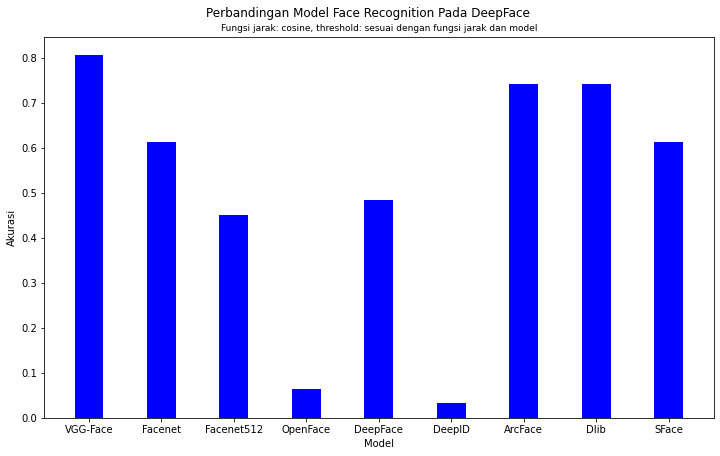

In [19]:
fig = plt.figure(figsize = (12, 7))
plt.bar(model, hasil_akurasi, color ='blue', width = 0.4)
plt.xlabel("Model")
plt.ylabel("Akurasi")
plt.suptitle("Perbandingan Model Face Recognition Pada DeepFace", y=0.94, fontsize=12)
plt.title("Fungsi jarak: cosine, threshold: sesuai dengan fungsi jarak dan model", fontsize=9)
plt.show()

Contoh data test dan hasil prediksinya

In [20]:
df_data_test_predict.sample(5)

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual,img_path_predict,label_foto_predict,anggota_kelas_predict,distance
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,leni_fitriani,yes,0.460286
15,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,haaland,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,leni_fitriani,yes,0.421514
20,/content/EL-7007-DeepFace/Data/Data_Test/non a...,galgadot,no,None,None,No,NaN
21,/content/EL-7007-DeepFace/Data/Data_Test/non a...,sby,no,/content/EL-7007-DeepFace/Data/Data_Set/non an...,sby,no,0.524738
17,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,imam_ekowicaksono,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,imam_ekowicaksono,yes,0.530792


### Dataset Perbandingan Model dan Metode Face Detector

Dengan menggunakan 3 model dengan memiliki akurasi terbaik pada data test, maka dilakukan proses eksperimen pada tekenik face detektor. Hal ini untuk mengetahui metode face detektor terbaik dari pada 3 model tersebut

Format nama file dataset: 
```
df2_data_m:NAMA_MODEL_REPRESENTASI_WAJAH_f_detect:TEKNIK_DETEKSI_WAJAH.csv
```

Contoh:

```
df2_data_m:ArcFace_f_detect:opencv.csv
df2_data_m:DeepFace_f_detect:opencv.csv
```

In [21]:
# Code untuk membuat dataset analisis
# Dataset Perbandingan Model dengan backend face detector
# Set runtime to GPU RAM

%pip install mediapipe

backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
model = ["VGG-Face", "ArcFace", "Dlib"]

for m in model:
  model_build = load_model(m) 
  if m == 'Dlib' or  m == 'SFace':
    input_shape = functions.find_input_shape(model_build)
  else:
    input_shape = model_build.input_shape[1:3]

  for b in backends:
    # Mendefinisikan dataset model untuk class "anggota kelas"
    data_anggota_kelas = read_directory(path_train + "anggota kelas")
    data_result_preprocess = preprocess_face(model_build, data_anggota_kelas, input_shape, enforce_detection=False, detector_backend=b)
    df_anggota_kelas = pd.DataFrame(data_result_preprocess, columns = ["label_foto", "img_path","face_detector_"+b, "embedding_"+ m])
    df_anggota_kelas['anggota_kelas'] = "yes"

    # Mendefinisikan dataset model untuk class "non anggota kelas"
    data_anggota_kelas = read_directory(path_train + "non anggota kelas")
    data_result_preprocess = preprocess_face(model_build, data_anggota_kelas, input_shape, enforce_detection=False, detector_backend=b)
    df_non_anggota_kelas = pd.DataFrame(data_result_preprocess, columns = ["label_foto", "img_path","face_detector_"+b, "embedding_"+ m])
    df_non_anggota_kelas['anggota_kelas'] = "no"

    # Join
    df = pd.concat([df_anggota_kelas, df_non_anggota_kelas]).reset_index(drop = True)
  
    # save file
    path_save = path_train + "df2_data_m:"+m+"_f_detect:"+b+".csv"
    df.to_pickle(path_save)
    print("Data disimpan di: " + path_save)

     |████████████████████████████████| 32.8 MB 428 kB/s 


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:opencv.csv


  0%|          | 0/25 [00:00<?, ?it/s]

deploy.prototxt will be downloaded...


Downloading...
From: https://github.com/opencv/opencv/raw/3.4.0/samples/dnn/face_detector/deploy.prototxt
To: /root/.deepface/weights/deploy.prototxt

28.1kB [00:00, 21.8MB/s]                   


res10_300x300_ssd_iter_140000.caffemodel will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
To: /root/.deepface/weights/res10_300x300_ssd_iter_140000.caffemodel

  0%|          | 0.00/10.7M [00:00<?, ?B/s]
100%|██████████| 10.7M/10.7M [00:00<00:00, 96.8MB/s]
100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:ssd.csv


  0%|          | 0/25 [00:00<?, ?it/s]Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2


shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded



  0%|          | 0.00/5.71M [00:00<?, ?B/s]
  9%|▉         | 524k/5.71M [00:00<00:01, 2.85MB/s]
100%|██████████| 5.71M/5.71M [00:00<00:00, 15.1MB/s]
100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:dlib.csv


100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:mtcnn.csv


  0%|          | 0/25 [00:00<?, ?it/s]

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  0%|          | 524k/119M [00:00<00:27, 4.23MB/s]
  3%|▎         | 3.67M/119M [00:00<00:06, 17.5MB/s]
  8%|▊         | 8.91M/119M [00:00<00:03, 30.9MB/s]
 16%|█▋        | 19.4M/119M [00:00<00:01, 57.2MB/s]
 23%|██▎       | 27.8M/119M [00:00<00:01, 66.2MB/s]
 31%|███▏      | 37.2M/119M [00:00<00:01, 74.0MB/s]
 39%|███▉      | 46.7M/119M [00:00<00:00, 72.4MB/s]
 48%|████▊     | 56.6M/119M [00:00<00:00, 80.2MB/s]
 57%|█████▋    | 67.6M/119M [00:01<00:00, 86.8MB/s]
 65%|██████▌   | 77.6M/119M [00:01<00:00, 89.6MB/s]
 75%|███████▍  | 88.6M/119M [00:01<00:00, 86.0MB/s]
 86%|████████▌ | 102M/119M [00:01<00:00, 98.1MB/s] 
100%|██████████| 119M/119M [00:01<00:00, 75.5MB/s]
100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:retinaface.csv


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:VGG-Face_f_detect:mediapipe.csv


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:opencv.csv


100%|██████████| 16/16 [00:03<00:00,  4.60it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:ssd.csv


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:dlib.csv


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:mtcnn.csv


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:retinaface.csv


100%|██████████| 16/16 [00:01<00:00,  9.23it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:ArcFace_f_detect:mediapipe.csv


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:opencv.csv


100%|██████████| 16/16 [00:02<00:00,  7.68it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:ssd.csv


100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:dlib.csv


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:mtcnn.csv


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:retinaface.csv


100%|██████████| 16/16 [00:00<00:00, 40.34it/s]

Data disimpan di: /content/EL-7007-DeepFace/Data/Data_Set/df2_data_m:Dlib_f_detect:mediapipe.csv


### Menghitung Akurasi Model Face Recognition dan Metode Face Detector

Proses perhitungan akurasi berdasarkan pada data test yang telah dibuat. Berikut data test yang dibuat dalam eksperimen ini

In [22]:
data_anggota_kelas_test = read_directory_file_name(path_test + "anggota kelas")
df_anggota_kelas_test = pd.DataFrame(data_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_anggota_kelas_test['anggota_kelas_aktual'] = "yes"
data_non_anggota_kelas_test = read_directory_file_name(path_test + "non anggota kelas")
df_non_anggota_kelas_test = pd.DataFrame(data_non_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_non_anggota_kelas_test['anggota_kelas_aktual'] = "no"
df_data_test = pd.concat([df_anggota_kelas_test, df_non_anggota_kelas_test]).reset_index(drop = True)
df_data_test.head()

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes


deskripsi data test

In [23]:
print("Jumlah Data:" + str(len(df_data_test)) )
yes_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'yes'] 
print("Jumlah Data Anggota Kelas:" + str(len(yes_df)) )
no_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'no'] 
print("Jumlah Data Non Anggota Kelas:" + str(len(no_df)) )

Jumlah Data:31
Jumlah Data Anggota Kelas:18
Jumlah Data Non Anggota Kelas:13


Menghitung akurasi model face recognition berdasarkan data test dengan **fungsi jarak "cosine"** dan **threshold 0.4**


In [24]:
backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
model = ["VGG-Face", "ArcFace", "Dlib"] #

hasil_akurasi_opencv = []
hasil_akurasi_ssd = []
hasil_akurasi_dlib = []
hasil_akurasi_mtcnn = []
hasil_akurasi_retinaface = []
hasil_akurasi_mediapipe = []

for m in tqdm(model):
    model_build = load_model(m) 
    if m == 'Dlib' or  m == 'SFace':
      input_shape = functions.find_input_shape(model_build)
    else:
      input_shape = model_build.input_shape[1:3]

    for b in backends:
      # Load database kelas dan non kelas
      df_data_set = pd.read_pickle(path_train+'df2_data_m:'+m+'_f_detect:'+b+'.csv') #database

      df_data_predicts = []
      for i, r in df_data_test.iterrows():
          img_test_representation = preprocess_face_DataTest(model_build,  r['img_path_aktual'], input_shape, enforce_detection=False,detector_backend=b)
          
          distances = []
          for index, row in df_data_set.iterrows(): # cek in database
              dist_ = dst.findCosineDistance (np.array(row['embedding_'+m]).astype('float'), img_test_representation[1])  
              distance = []
              distance.append(row['img_path'])
              distance.append(row['label_foto'])
              distance.append(row['anggota_kelas'])
              distance.append(dist_)
              distances.append(distance)

          df_distance = pd.DataFrame(distances, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
          threshold = dst.findThreshold(m, 'cosine') # 0.4
          df_data_predict_threshold = df_distance[df_distance["distance"] <= threshold].sort_values(by=["distance"], ascending=True).reset_index(drop=True)
          
          df_data_predict = []
          if(len(df_data_predict_threshold)> 0):
            # Ambil baris pertama - Nilai distance yang paling kecil
            df_data_predict.append(df_data_predict_threshold.iloc[0]['img_path_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['label_foto_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['anggota_kelas_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['distance'])
          else:
            df_data_predict.append(None)
            df_data_predict.append(None)
            df_data_predict.append("No")
            df_data_predict.append(None)
          df_data_predicts.append(df_data_predict)

      df_data_predicts_rst = pd.DataFrame(df_data_predicts, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
      df_data_test_predict_model_detektor = pd.concat([df_data_test, df_data_predicts_rst], axis=1)

      label_actual = df_data_test_predict_model_detektor['anggota_kelas_aktual'].tolist()
      label_predict = df_data_test_predict_model_detektor['anggota_kelas_predict'].tolist()
      accuracy = accuracy_score(label_actual, label_predict)
      
      if b == 'opencv':
        hasil_akurasi_opencv.append(accuracy)
      if b == 'ssd':
        hasil_akurasi_ssd.append(accuracy)
      if b == 'dlib':
        hasil_akurasi_dlib.append(accuracy)
      if b == 'mtcnn':
        hasil_akurasi_mtcnn.append(accuracy)
      if b == 'retinaface':
        hasil_akurasi_retinaface.append(accuracy)
      if b == 'mediapipe':
        hasil_akurasi_mediapipe.append(accuracy)

100%|██████████| 3/3 [06:30<00:00, 130.02s/it]


In [25]:
print(hasil_akurasi_opencv)
print(hasil_akurasi_ssd)
print(hasil_akurasi_dlib)
print(hasil_akurasi_mtcnn)
print(hasil_akurasi_retinaface)
print(hasil_akurasi_mediapipe)

[0.8064516129032258, 0.7419354838709677, 0.7419354838709677]
[0.8064516129032258, 0.8064516129032258, 0.5806451612903226]
[0.9032258064516129, 0.8709677419354839, 0.8387096774193549]
[0.8387096774193549, 0.8387096774193549, 0.7741935483870968]
[0.8387096774193549, 0.8387096774193549, 0.6451612903225806]
[0.6451612903225806, 0.6129032258064516, 0.5161290322580645]


In [26]:
import re
def truncate(num):
    return re.sub(r'^(\d+\.\d{,2})\d*$',r'\1',str(num))
    
hasil_akurasi_opencv = [ float(truncate(x * 100)) for x in hasil_akurasi_opencv]
hasil_akurasi_ssd = [float(truncate(x * 100)) for x in hasil_akurasi_ssd]
hasil_akurasi_dlib = [float(truncate(x * 100)) for x in hasil_akurasi_dlib]
hasil_akurasi_mtcnn = [float(truncate(x * 100)) for x in hasil_akurasi_mtcnn]
hasil_akurasi_retinaface = [float(truncate(x * 100)) for x in hasil_akurasi_retinaface]
hasil_akurasi_mediapipe = [float(truncate(x * 100)) for x in hasil_akurasi_mediapipe]

Menampilkan hasil akurasi dalam bentuk grafik bar

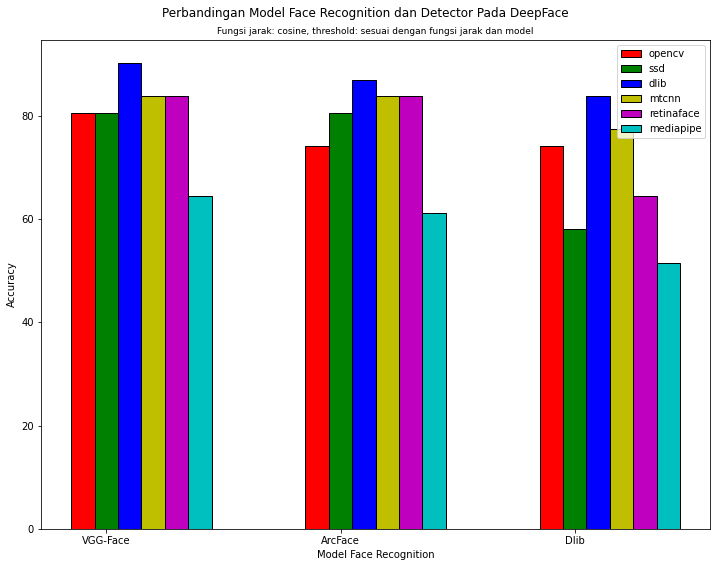

In [27]:
model = ["VGG-Face", "ArcFace", "Dlib"]

barWidth = 0.10
fig = plt.subplots(figsize =(12, 9))

IT = hasil_akurasi_opencv
ECE = hasil_akurasi_ssd
CSE = hasil_akurasi_dlib
CSX = hasil_akurasi_mtcnn
CSY = hasil_akurasi_retinaface
CSW = hasil_akurasi_mediapipe
 
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
 
plt.bar(br1, IT, color ='r', width = barWidth,
        edgecolor ='black', label ='opencv')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='black', label ='ssd')
plt.bar(br3, CSE, color ='b', width = barWidth,
        edgecolor ='black', label ='dlib')
plt.bar(br4, CSX, color ='y', width = barWidth,
        edgecolor ='black', label ='mtcnn')
plt.bar(br5, CSY, color ='m', width = barWidth,
        edgecolor ='black', label ='retinaface')
plt.bar(br6, CSW, color ='c', width = barWidth,
        edgecolor ='black', label ='mediapipe')
 
plt.xlabel("Model Face Recognition")
plt.ylabel('Accuracy')
plt.suptitle("Perbandingan Model Face Recognition dan Detector Pada DeepFace", y=0.93, fontsize=12)
plt.title("Fungsi jarak: cosine, threshold: sesuai dengan fungsi jarak dan model", fontsize=9)
plt.xticks([r + barWidth for r in range(len(IT))],model)
 
plt.legend()
plt.show()

Contoh data test dan hasil prediksinya

In [28]:
df_data_test_predict_model_detektor

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual,img_path_predict,label_foto_predict,anggota_kelas_predict,distance
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,meza_silvana,yes,0.029100
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,mina_ismu_rahayu,yes,0.067245
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,dewi_tresnawati,yes,0.052906
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes,/content/EL-7007-DeepFace/Data/Data_Set/non an...,sandiaga_uno,no,0.041385
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,meredita_susanty,yes,0.046758
5,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,adiyasa_nurfalah,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,adiyasa_nurfalah,yes,0.044549
6,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,mina_ismu_rahayu,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,mina_ismu_rahayu,yes,0.042774
7,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,arief_sartono,yes,/content/EL-7007-DeepFace/Data/Data_Set/non an...,ridwan_kamil,no,0.033772
8,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,leni_fitriani,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,leni_fitriani,yes,0.043990
9,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,handoko_supeno,yes,/content/EL-7007-DeepFace/Data/Data_Set/non an...,Bambanf,no,0.062315


## Analisis Fungsi Jarak

Dengan menggunakan 3 model dan teknik face detektor dengan memiliki akurasi terbaik pada data test dari proses sebelumnya, maka dilakukan proses eksperimen pada jenis fungsi jarak yang digunakan. Hal ini untuk mengetahui fungsi jarak terbaik yang digunakan. Sehingga pada eksperimen ini menggunakan Dataset Perbandingan Model dan Metode Face Detector. Adapun model face recognition + metode face detector yang digunakan adalah:

1. VGG-Face + dlib
2. ArcFace + dlib
3. Dlib + dlib

Sedangkan fungsi jarak yang akan dianalisis adalah:
1. Cosine
2. Euclidean
3. Euclidean_l2

### Menghitung Akurasi pada Fungsi Jarak

Proses perhitungan akurasi berdasarkan pada data test yang telah dibuat. Berikut data test yang dibuat dalam eksperimen ini

In [29]:
data_anggota_kelas_test = read_directory_file_name(path_test + "anggota kelas")
df_anggota_kelas_test = pd.DataFrame(data_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_anggota_kelas_test['anggota_kelas_aktual'] = "yes"
data_non_anggota_kelas_test = read_directory_file_name(path_test + "non anggota kelas")
df_non_anggota_kelas_test = pd.DataFrame(data_non_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_non_anggota_kelas_test['anggota_kelas_aktual'] = "no"
df_data_test = pd.concat([df_anggota_kelas_test, df_non_anggota_kelas_test]).reset_index(drop = True)
df_data_test.head()

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes


deskripsi data

In [30]:
print("Jumlah Data:" + str(len(df_data_test)) )
yes_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'yes'] 
print("Jumlah Data Anggota Kelas:" + str(len(yes_df)) )
no_df = df_data_test[df_data_test['anggota_kelas_aktual'] == 'no'] 
print("Jumlah Data Non Anggota Kelas:" + str(len(no_df)) )

Jumlah Data:31
Jumlah Data Anggota Kelas:18
Jumlah Data Non Anggota Kelas:13


Menghitung akurasi model face recognition berdasarkan data test dengan **fungsi jarak** dan **threshold sesuai dengan fungsi jarak yang digunakan**


In [31]:
distance_function = ['cosine', 'euclidean', 'euclidean_l2']
best_model_detector = ['VGG-Face_dlib',
                       'ArcFace_dlib',
                       'Dlib_dlib' ]
hasil_akurasi_cosine = []
hasil_akurasi_euclidean = []
hasil_akurasi_euclidean_l2 = []

for bmd in tqdm(best_model_detector):
    
    mode_detector = bmd.split('_')
    m = mode_detector[0]
    b = mode_detector[1]

    model_build = load_model(m) 
    if m == 'Dlib' or  m == 'SFace':
      input_shape = functions.find_input_shape(model_build)
    else:
      input_shape = model_build.input_shape[1:3]

    # Load database kelas dan non kelas
    df_data_set = pd.read_pickle(path_train+'df2_data_m:'+m+'_f_detect:'+b+'.csv') #database

    for d in distance_function:
      df_data_predicts = []
      for i, r in df_data_test.iterrows():
          img_test_representation = preprocess_face_DataTest(model_build,  r['img_path_aktual'], input_shape, enforce_detection=False,detector_backend=b)
          distances = []
          for index, row in df_data_set.iterrows(): # cek in database
              dist_ = dst.findCosineDistance (np.array(row['embedding_'+m]).astype('float'), img_test_representation[1])  
              distance = []
              distance.append(row['img_path'])
              distance.append(row['label_foto'])
              distance.append(row['anggota_kelas'])
              distance.append(dist_)
              distances.append(distance)

          df_distance = pd.DataFrame(distances, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
          threshold = dst.findThreshold(m, d) # sesui dengan fungsi jarak
          df_data_predict_threshold = df_distance[df_distance["distance"] <= threshold].sort_values(by=["distance"], ascending=True).reset_index(drop=True)
          
          df_data_predict = []
          if(len(df_data_predict_threshold)> 0):
            # Ambil baris pertama - Nilai distance yang paling kecil
            df_data_predict.append(df_data_predict_threshold.iloc[0]['img_path_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['label_foto_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['anggota_kelas_predict'])
            df_data_predict.append(df_data_predict_threshold.iloc[0]['distance'])
          else:
            df_data_predict.append(None)
            df_data_predict.append(None)
            df_data_predict.append("No")
            df_data_predict.append(None)
          df_data_predicts.append(df_data_predict)

      df_data_predicts_rst = pd.DataFrame(df_data_predicts, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
      df_data_test_predict = pd.concat([df_data_test, df_data_predicts_rst], axis=1)

      label_actual = df_data_test_predict['anggota_kelas_aktual'].tolist()
      label_predict = df_data_test_predict['anggota_kelas_predict'].tolist()
      accuracy = accuracy_score(label_actual, label_predict)
      if d == 'cosine':
        hasil_akurasi_cosine.append(accuracy)
      if d == 'cosine':
        hasil_akurasi_euclidean.append(accuracy)
      if d == 'euclidean_l2':
        hasil_akurasi_euclidean_l2.append(accuracy)

100%|██████████| 3/3 [04:45<00:00, 95.24s/it]


In [41]:
print(hasil_akurasi_cosine)
print(hasil_akurasi_euclidean)
print(hasil_akurasi_euclidean_l2)

[90.32, 87.09, 83.87]
[90.32, 87.09, 83.87]
[90.32, 90.32, 87.09]


In [42]:
import re
def truncate(num):
    return re.sub(r'^(\d+\.\d{,2})\d*$',r'\1',str(num))
    
hasil_akurasi_cosine = [ float(truncate(x * 100)) for x in hasil_akurasi_cosine]
hasil_akurasi_euclidean = [float(truncate(x * 100)) for x in hasil_akurasi_euclidean]
hasil_akurasi_euclidean_l2 = [float(truncate(x * 100)) for x in hasil_akurasi_euclidean_l2]

Menampilkan hasil akurasi dalam bentuk grafik bar

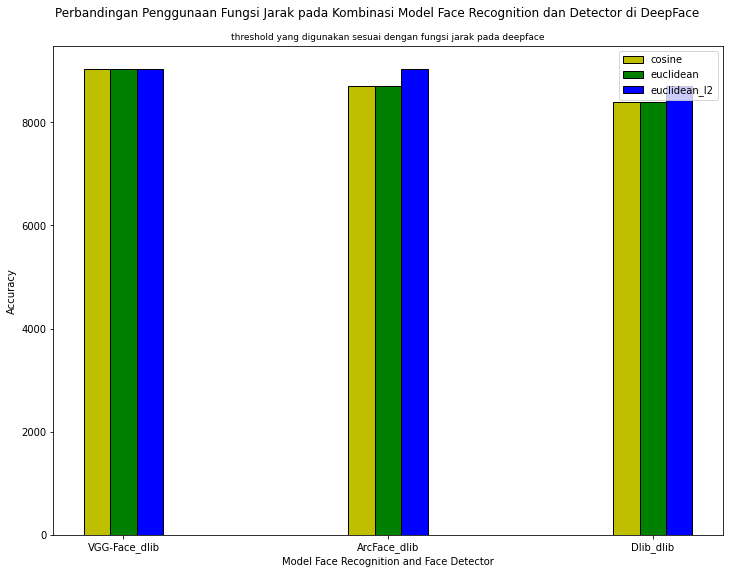

In [43]:
best_model_detector = ['VGG-Face_dlib',
                       'ArcFace_dlib',
                       'Dlib_dlib' ]

barWidth = 0.10
fig = plt.subplots(figsize =(12, 9))

IT = hasil_akurasi_cosine
ECE = hasil_akurasi_euclidean
CSE = hasil_akurasi_euclidean_l2
 
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
plt.bar(br1, IT, color ='y', width = barWidth,
        edgecolor ='black', label ='cosine')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='black', label ='euclidean')
plt.bar(br3, CSE, color ='b', width = barWidth,
        edgecolor ='black', label ='euclidean_l2')
 
plt.xlabel("Model Face Recognition and Face Detector")
plt.ylabel('Accuracy')
plt.suptitle("Perbandingan Penggunaan Fungsi Jarak pada Kombinasi Model Face Recognition dan Detector di DeepFace", y=0.94, fontsize=12)
plt.title("threshold yang digunakan sesuai dengan fungsi jarak pada deepface", fontsize=9)
plt.xticks([r + barWidth for r in range(len(IT))], best_model_detector)
 
plt.legend()
plt.show()

# Implementasi


Pada implementasi sistem mampu mengidetifikasi wajah dengan alur sebagai berikut:

1. Jika sistem berhasil mengenali wajah: `<Foto+Label dari Test Data> <Foto+Label dari Database pas foto> Benar/Salah`

2. Jika sistem tidak berhasil mengenali wajah: `<Foto+Label Test Data> Unknown Benar/Salah `

## Menampilkan Data yang Berhasil dan Gagal Diklasifikasikan

Pada proses implementasi menggunakan 
1. Model face recognition **VGG-Face**
2. Face detector **dlib**
3. Fungsi jarak **cosine**

In [44]:
data_anggota_kelas_test = read_directory_file_name(path_test + "anggota kelas")
df_anggota_kelas_test = pd.DataFrame(data_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_anggota_kelas_test['anggota_kelas_aktual'] = "yes"
data_non_anggota_kelas_test = read_directory_file_name(path_test + "non anggota kelas")
df_non_anggota_kelas_test = pd.DataFrame(data_non_anggota_kelas_test, columns = [ "img_path_aktual", "label_foto_aktual"])
df_non_anggota_kelas_test['anggota_kelas_aktual'] = "no"
df_data_test = pd.concat([df_anggota_kelas_test, df_non_anggota_kelas_test]).reset_index(drop = True)
df_data_test

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes
5,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,adiyasa_nurfalah,yes
6,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,mina_ismu_rahayu,yes
7,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,arief_sartono,yes
8,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,leni_fitriani,yes
9,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,handoko_supeno,yes


Parameter
1. Model: VGG-Face
2. Face_detector: dlib
3. Fungsi_jarak: cosine


In [45]:
# {Model:Dlib, Face_detector:dlib, Fungsi_jarak:cosine}
model_build = load_model('VGG-Face') 
if m == 'Dlib' or  m == 'SFace':
  input_shape = functions.find_input_shape(model_build)
else:
  input_shape = model_build.input_shape[1:3]
df_data_set = pd.read_pickle(path_train+'df2_data_m:VGG-Face_f_detect:dlib.csv')
threshold = dst.findThreshold('VGG-Face', 'cosine')
print("threshold: ", threshold)
df_data_predicts = []
for i, r in tqdm(df_data_test.iterrows(), total=df_data_test.shape[0]):
    img_test_representation = preprocess_face_DataTest(model_build,  r['img_path_aktual'], input_shape, enforce_detection=False,detector_backend='dlib')
    distances = []
    for index, row in df_data_set.iterrows():
        dist_ = dst.findCosineDistance (np.array(row['embedding_VGG-Face']).astype('float'), img_test_representation[1])  
        distance = []
        distance.append(row['img_path'])
        distance.append(row['label_foto'])
        distance.append(row['anggota_kelas'])
        distance.append(dist_)
        distances.append(distance)

    df_distance = pd.DataFrame(distances, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
    df_data_predict_threshold = df_distance[df_distance["distance"] <= threshold].sort_values(by=["distance"], ascending=True).reset_index(drop=True)
    df_data_predict = []
    if(len(df_data_predict_threshold)> 0):
      df_data_predict.append(df_data_predict_threshold.iloc[0]['img_path_predict'])
      df_data_predict.append(df_data_predict_threshold.iloc[0]['label_foto_predict'])
      df_data_predict.append(df_data_predict_threshold.iloc[0]['anggota_kelas_predict'])
      df_data_predict.append(df_data_predict_threshold.iloc[0]['distance'])
    else:
      df_data_predict.append(None)
      df_data_predict.append(None)
      df_data_predict.append("No")
      df_data_predict.append(None)
    df_data_predicts.append(df_data_predict)

df_data_predicts_rst = pd.DataFrame(df_data_predicts, columns = ["img_path_predict","label_foto_predict","anggota_kelas_predict","distance"])
df_data_test_predict = pd.concat([df_data_test, df_data_predicts_rst], axis=1)

label_actual = df_data_test_predict['anggota_kelas_aktual'].tolist()
label_predict = df_data_test_predict['anggota_kelas_predict'].tolist()
accuracy = accuracy_score(label_actual, label_predict)
print("\nAccuracy : {:.4f}%".format(accuracy*100))

threshold:  0.4


100%|██████████| 31/31 [00:34<00:00,  1.10s/it]


Accuracy : 90.3226%


In [46]:
df_data_test_predict

,img_path_aktual,label_foto_aktual,anggota_kelas_aktual,img_path_predict,label_foto_predict,anggota_kelas_predict,distance
0,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meza_silvana,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,meza_silvana,yes,0.121514
1,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,varuliantor-dear,yes,/content/EL-7007-DeepFace/Data/Data_Set/non an...,ridwan_kamil,no,0.191778
2,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,dewi_tresnawati,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,dewi_tresnawati,yes,0.132880
3,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,ahmad_luky_ramdani,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,ahmad_luky_ramdani,yes,0.183501
4,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,meredita_susanty,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,meredita_susanty,yes,0.195175
5,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,adiyasa_nurfalah,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,adiyasa_nurfalah,yes,0.123256
6,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,mina_ismu_rahayu,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,mina_ismu_rahayu,yes,0.150703
7,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,arief_sartono,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,arief_sartono,yes,0.293318
8,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,leni_fitriani,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,leni_fitriani,yes,0.131430
9,/content/EL-7007-DeepFace/Data/Data_Test/anggo...,handoko_supeno,yes,/content/EL-7007-DeepFace/Data/Data_Set/anggot...,handoko_supeno,yes,0.236630


  0%|          | 0/31 [00:00<?, ?it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/meza_silvana.jpg


  6%|▋         | 2/31 [00:00<00:09,  3.19it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/varuliantor-dear.jpg


 10%|▉         | 3/31 [00:00<00:06,  4.32it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/dewi_tresnawati.jpg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/ahmad_luky_ramdani.jpg


 16%|█▌        | 5/31 [00:01<00:04,  6.35it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/meredita_susanty.jpg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/adiyasa_nurfalah.jpg


 19%|█▉        | 6/31 [00:01<00:04,  6.06it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/mina_ismu_rahayu.jpg


 23%|██▎       | 7/31 [00:02<00:11,  2.05it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/arief_sartono.jpg


 35%|███▌      | 11/31 [00:04<00:07,  2.84it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/leni_fitriani.jpg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/handoko_supeno.jpg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/lathifah_arief.jpg


 42%|████▏     | 13/31 [00:04<00:04,  4.06it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/riyanto_riyanto.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/rahman_indra_kesuma.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/ricky_isfandiari.jpeg


 48%|████▊     | 15/31 [00:05<00:04,  3.51it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/adiyasa_nurfalah.jpeg


 52%|█████▏    | 16/31 [00:05<00:04,  3.71it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/haaland.png


 55%|█████▍    | 17/31 [00:05<00:03,  4.07it/s]

/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/hartanto_tantriawan.jpg
/content/EL-7007-DeepFace/Data/Data_Test/anggota kelas/imam_ekowicaksono.jpg


 61%|██████▏   | 19/31 [00:05<00:02,  5.02it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/Vladimir_Putin.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/Elon_Musk.jpeg


 68%|██████▊   | 21/31 [00:06<00:01,  5.75it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/galgadot.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/sby.jpeg


 74%|███████▍  | 23/31 [00:06<00:01,  6.42it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/ridwan_kamil.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/sri_mulyani_indrawati.jpeg


 77%|███████▋  | 24/31 [00:06<00:01,  5.29it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/airin_rachmi_diany.jpeg


 81%|████████  | 25/31 [00:07<00:01,  3.48it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/revalina.jpeg


 84%|████████▍ | 26/31 [00:07<00:01,  3.23it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/sandiaga_uno.jpeg


 90%|█████████ | 28/31 [00:08<00:00,  3.11it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/gozali.jpeg


 94%|█████████▎| 29/31 [00:08<00:00,  3.32it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/maudy_ayunda.jpeg
/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/Volodymyr_Zelensky.jpeg


 97%|█████████▋| 30/31 [00:08<00:00,  3.35it/s]

/content/EL-7007-DeepFace/Data/Data_Test/non anggota kelas/haaland.png


100%|██████████| 31/31 [00:09<00:00,  3.35it/s]


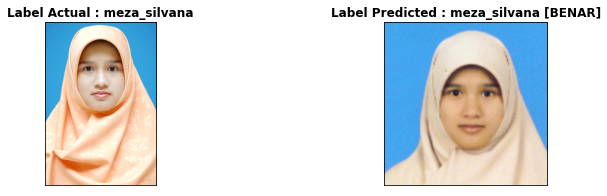

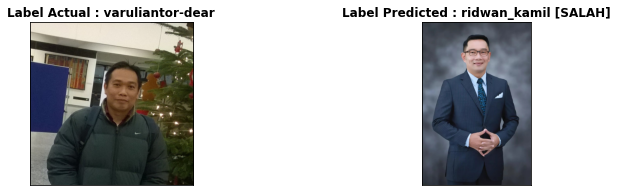

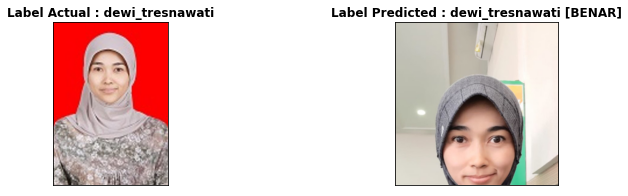

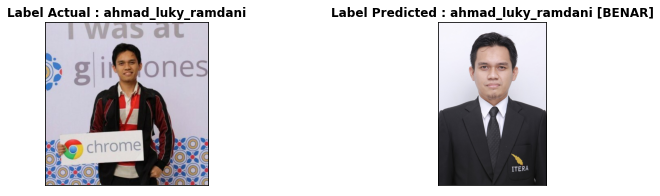

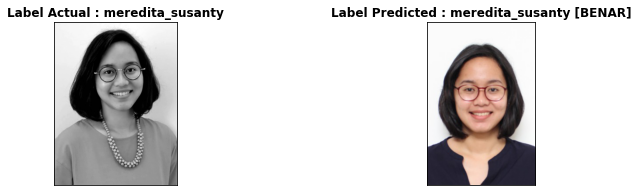

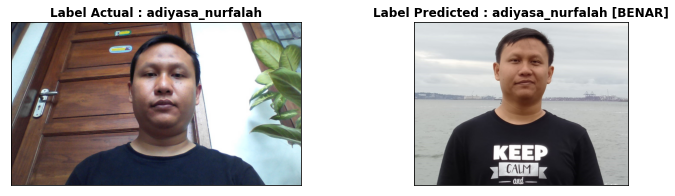

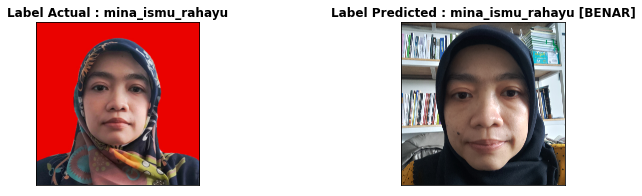

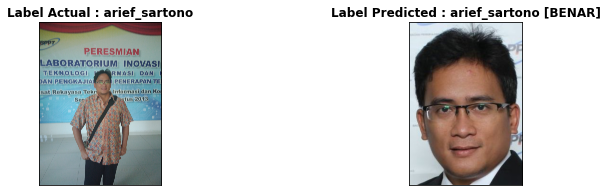

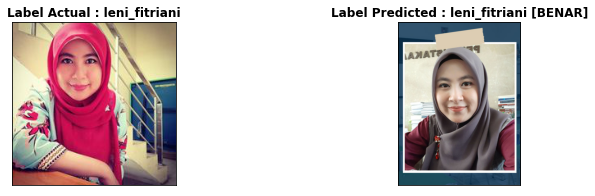

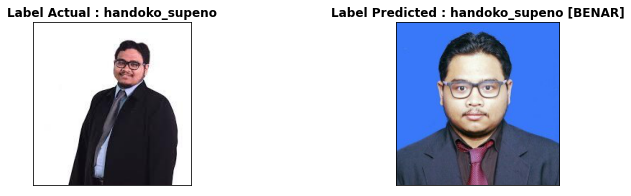

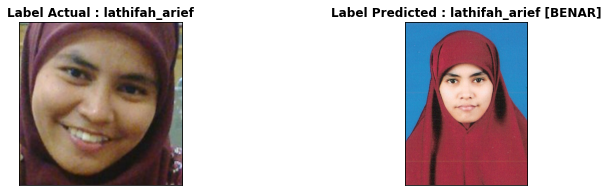

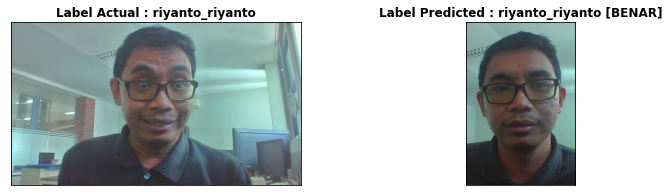

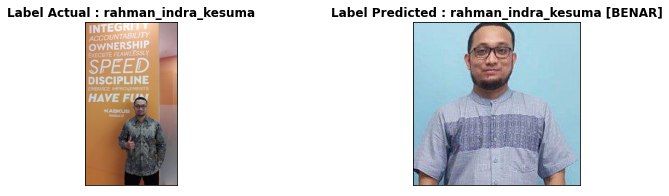

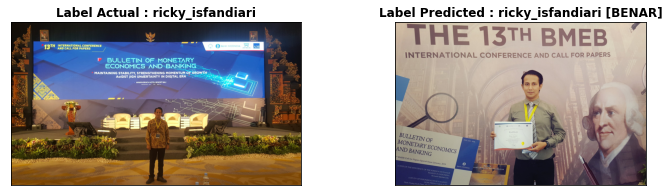

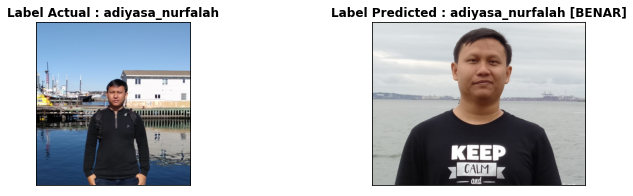

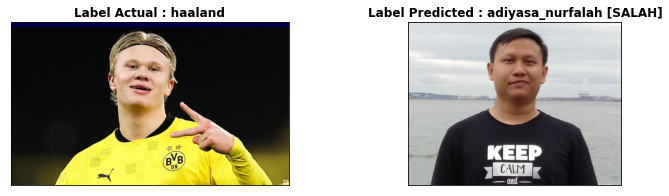

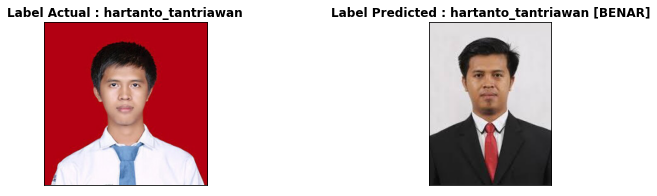

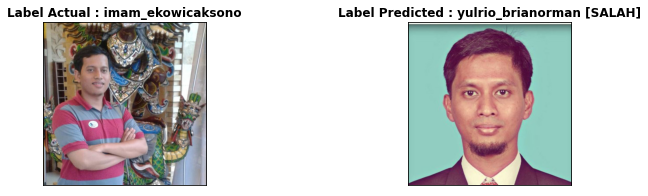

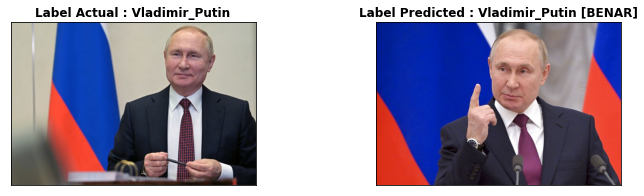

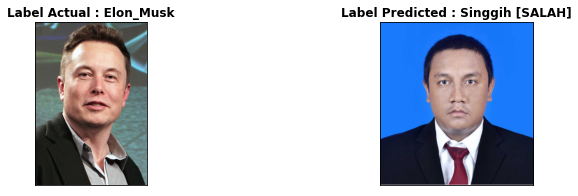

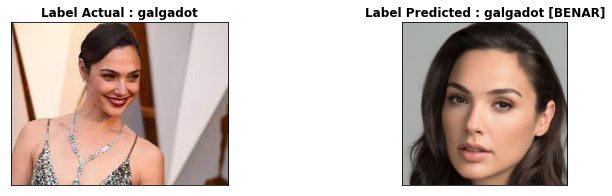

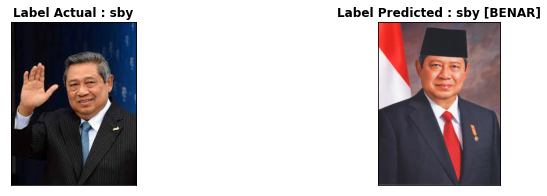

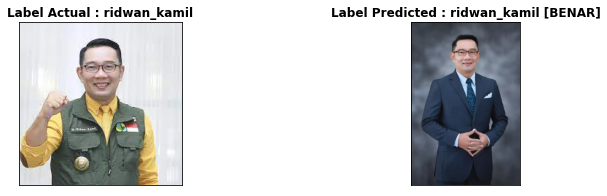

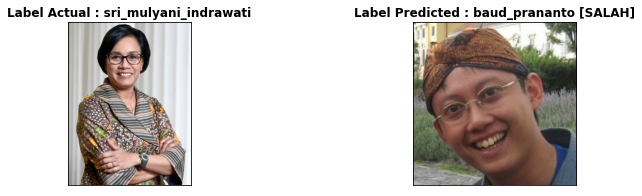

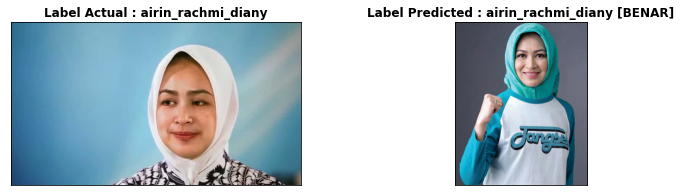

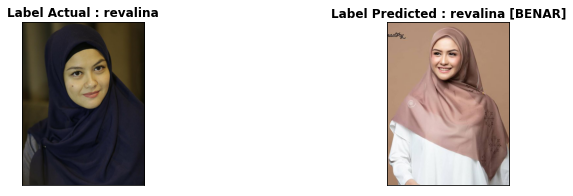

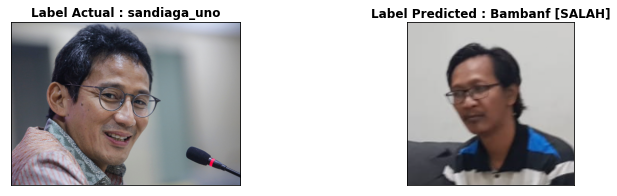

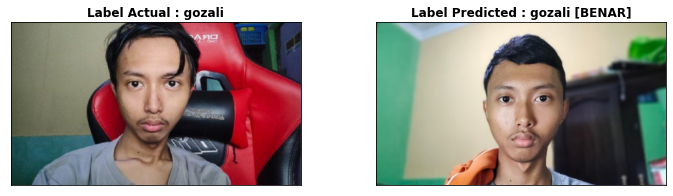

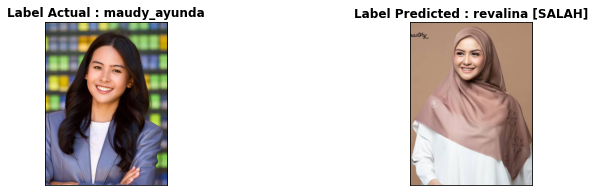

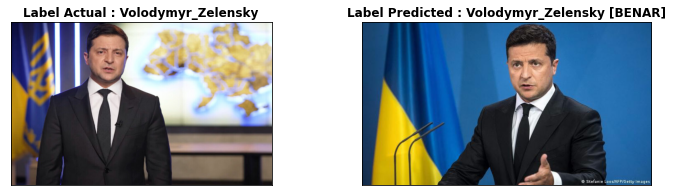

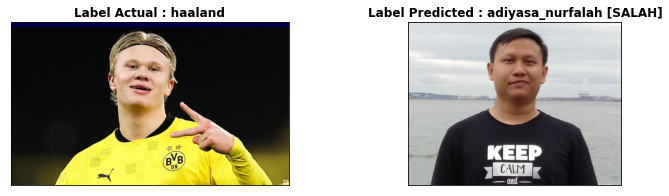

In [47]:
import matplotlib.image as mpimg

for i, r in tqdm(df_data_test_predict.iterrows(), total=df_data_test.shape[0]):
  plt.figure(figsize=(12,3))
  label = "Label Actual : "+r['label_foto_aktual']
  plt.subplot(1,2,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(label, fontweight ='bold', fontsize = 12)

  print(r['img_path_aktual'])
  img = mpimg.imread(r['img_path_aktual'])
  imgplot = plt.imshow(img)

  if r['label_foto_aktual'] == r['label_foto_predict']:
    status = "[BENAR]"
    label_ = "Label Predicted : "+r['label_foto_predict']+" "+status
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(label_, fontweight ='bold', fontsize = 12)

    img = mpimg.imread(r['img_path_predict'])
    imgplot = plt.imshow(img)
  else:
    status = "[SALAH]"
    label_ = "Label Predicted : "+r['label_foto_predict']+" "+status
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(label_, fontweight ='bold', fontsize = 12)

    if r['img_path_predict'] == None:
      npArray = np.array([[[0, 0, 0, 0]]], dtype='uint8')
      plt.imshow(npArray, interpolation='nearest')
    else:
      img = mpimg.imread(r['img_path_predict'])
      imgplot = plt.imshow(img)
